In [1]:
import os
import math
import timm
import glob
import torch
import random
import numpy as np
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim

In [ ]:
import torchvision.models as models

class VGGPerceptualLoss(nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        # Load VGG19 pretrained on ImageNet
        vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features
        
        # We only need the first few layers (to capture edges/shapes)
        # Extracting up to layer 35 usually gives good structural features
        self.blocks = nn.ModuleList([
            vgg[:4].eval(),
            vgg[4:9].eval(),
            vgg[9:18].eval(),
            vgg[18:27].eval()
        ])
        
        # Freeze VGG parameters (we don't train this!)
        for bl in self.blocks:
            for p in bl.parameters():
                p.requires_grad = False
                
        # Normalization statistics for VGG
        self.mean = torch.nn.Parameter(torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1))
        self.std = torch.nn.Parameter(torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1))
        self.resize = resize

    def forward(self, input, target):
        # 1. Normalize inputs for VGG
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
            
        input = (input - self.mean) / self.std
        target = (target - self.mean) / self.std
        
        loss = 0.0
        x = input
        y = target
        
        # 2. Compare features at different scales
        for block in self.blocks:
            x = block(x)
            y = block(y)
            # L1 Loss between features
            loss += torch.nn.functional.l1_loss(x, y)
            
        return loss

In [3]:
class CachedDataset(Dataset):
    def __init__(self, file_list, upscale_factor=4):
        self.upscale_factor = upscale_factor
        
        # 1. Define Transforms
        self.hr_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
        
        self.lr_transform = transforms.Compose([
            transforms.Resize((256 // upscale_factor, 256 // upscale_factor)),
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])

        # 2. Pre-load ALL images into RAM now
        print(f"⏳ Caching {len(file_list)} images to RAM... this takes a moment but speeds up training huge!")
        self.data = []
        for img_path in tqdm(file_list):
            try:
                # Open and convert once
                image = Image.open(img_path).convert("RGB")
                
                # Apply transforms immediately and store TENSORS, not file paths
                hr_tensor = self.hr_transform(image)
                lr_tensor = self.lr_transform(image)
                
                self.data.append((lr_tensor, hr_tensor))
            except:
                pass # Skip broken images

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 3. Super fast retrieval (no disk I/O, no resizing!)
        return self.data[idx]

In [4]:
class SuperResolutionDataset(Dataset):
    def __init__(self, file_list, upscale_factor=4):
        self.file_list = file_list
        self.upscale_factor = upscale_factor
        
        self.hr_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
        self.lr_transform = transforms.Compose([
            transforms.Resize((256 // upscale_factor, 256 // upscale_factor)),
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        image = Image.open(img_path).convert("RGB")
        hr = self.hr_transform(image)
        lr = self.lr_transform(image)
        return lr, hr


In [5]:
# Get all image paths from all subfolders
all_images = glob.glob("/Users/helenacooper/Desktop/9. semester/applied_deep_learning/images/**/*.jpg", recursive=True)
all_images += glob.glob("/Users/helenacooper/Desktop/9. semester/applied_deep_learning/images/**/*.png", recursive=True)
all_images += glob.glob("/Users/helenacooper/Desktop/9. semester/applied_deep_learning/images/**/*.jpeg", recursive=True)

# Split into train/test (e.g., 80% train, 20% test)
train_files, test_files = train_test_split(all_images, test_size=0.2, random_state=42)

# To these lines:
print("Processing Training Set...")
train_dataset = CachedDataset(train_files)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

print("Processing Test Set...")
test_dataset = CachedDataset(test_files)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Processing Training Set...
⏳ Caching 548 images to RAM... this takes a moment but speeds up training huge!


 81%|████████  | 443/548 [00:43<00:11,  8.85it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (114350832 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 548/548 [00:55<00:00,  9.92it/s]


Processing Test Set...
⏳ Caching 137 images to RAM... this takes a moment but speeds up training huge!


 37%|███▋      | 51/137 [00:05<00:16,  5.16it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (91414305 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 45%|████▌     | 62/137 [00:07<00:08,  9.00it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (102539520 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 137/137 [00:14<00:00,  9.15it/s]


In [6]:
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0  # assuming normalized to [0, 1]
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def calculate_ssim(img1, img2):
    # skimage expects H×W×C
    return ssim(img1, img2, data_range=1.0, channel_axis=2)


In [7]:
class DoubleConv(nn.Module):
    """(Conv2d -> ReLU) x2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [8]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()

        # Encoder (Downsampling)
        # We use the DoubleConv block you already have in your code!
        self.enc1 = DoubleConv(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(256, 512)

        # Decoder (Upsampling + SKIP CONNECTIONS)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256) # Input is 512 because 256 (up3) + 256 (skip)
        
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128) # Input is 256 because 128 (up2) + 128 (skip)
        
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)  # Input is 128 because 64 (up1) + 64 (skip)

        self.final_conv = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        # Bottleneck
        b = self.bottleneck(p3)

        # Decoder with Skips
        # We concatenate the encoder output (e3) with the upsampled bottleneck (x)
        x = self.up3(b)
        x = torch.cat([x, e3], dim=1) 
        x = self.dec3(x)

        x = self.up2(x)
        x = torch.cat([x, e2], dim=1)
        x = self.dec2(x)

        x = self.up1(x)
        x = torch.cat([x, e1], dim=1)
        x = self.dec1(x)

        return self.final_conv(x)

In [9]:
def visualize_sample(model, loader, device, num_samples=3):
    model.eval() # Set model to evaluation mode
    
    # Get a single batch
    with torch.no_grad():
        low_res, high_res = next(iter(loader))
        low_res = low_res.to(device)
        
        # Get model prediction
        outputs = model(low_res)
        
    # Move images to CPU and numpy for plotting
    # We clip values to [0, 1] to avoid display errors with matplotlib
    low_res = low_res.cpu().permute(0, 2, 3, 1).numpy().clip(0, 1)
    outputs = outputs.cpu().permute(0, 2, 3, 1).numpy().clip(0, 1)
    high_res = high_res.cpu().permute(0, 2, 3, 1).numpy().clip(0, 1)

    plt.figure(figsize=(12, 4 * num_samples))
    
    for i in range(num_samples):
        # Plot Low Res (Input)
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(low_res[i])
        plt.title("Input (Blurry)")
        plt.axis("off")

        # Plot Prediction (Output)
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(outputs[i])
        plt.title("Model Prediction")
        plt.axis("off")

        # Plot High Res (Target)
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(high_res[i])
        plt.title("Ground Truth (Sharp)")
        plt.axis("off")
        
    plt.tight_layout()
    plt.show() # If running in a script, you might want plt.savefig(f"epoch_results.png")
    
    model.train() # IMPORTANT: Switch back to training mode!

In [10]:
class CharbonnierLoss(nn.Module):
    """L1 Loss variant that is differentiable and MPS-safe."""
    def __init__(self, eps=1e-6):
        super(CharbonnierLoss, self).__init__()
        self.eps = eps

    def forward(self, x, y):
        diff = x - y
        loss = torch.sqrt(diff * diff + self.eps)
        return torch.mean(loss)

In [11]:
# 1. Initialize the NEW model
# Replace your current device line with this:
device = torch.device(
    "cuda" if torch.cuda.is_available() 
    else "mps" if torch.backends.mps.is_available() 
    else "cpu"
)
print(f"🚀 Training on: {device}")
model = SimpleUNet().to(device)

class CombinedLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=0.1):
        super(CombinedLoss, self).__init__()
        self.pixel_loss = CharbonnierLoss()
        self.perceptual_loss = VGGPerceptualLoss().to(device) # Move VGG to GPU!
        self.alpha = alpha # Weight for Pixel Loss
        self.beta = beta   # Weight for Perceptual Loss

    def forward(self, pred, target):
        # Pixel Loss ensures correct colors/positions
        l_pixel = self.pixel_loss(pred, target)
        
        # Perceptual Loss ensures realistic star shapes
        l_perc = self.perceptual_loss(pred, target)
        
        return self.alpha * l_pixel + self.beta * l_perc

# Note: We do NOT need to freeze anything because we are training from scratch.
# This solves the "Frozen Brain" problem.

# 2. Change Loss to L1 (MAE)
# This solves the "MSE Blur" problem.
#criterion = nn.L1Loss() 
#criterion = CharbonnierLoss().to(device)
criterion = CombinedLoss(alpha=1.0, beta=0.05).to(device)
# 3. Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

🚀 Training on: mps


  0%|          | 0/68 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 68/68 [29:59<00:00, 26.46s/it]


Epoch [1/10], Loss: 0.2023


100%|██████████| 68/68 [41:09<00:00, 36.31s/it]


Epoch [2/10], Loss: 0.1093


100%|██████████| 68/68 [37:05<00:00, 32.73s/it]


Epoch [3/10], Loss: 0.0973


100%|██████████| 68/68 [35:16<00:00, 31.12s/it]


Epoch [4/10], Loss: 0.0920


100%|██████████| 68/68 [37:33<00:00, 33.14s/it]


Epoch [5/10], Loss: 0.0900
Creating visualization...


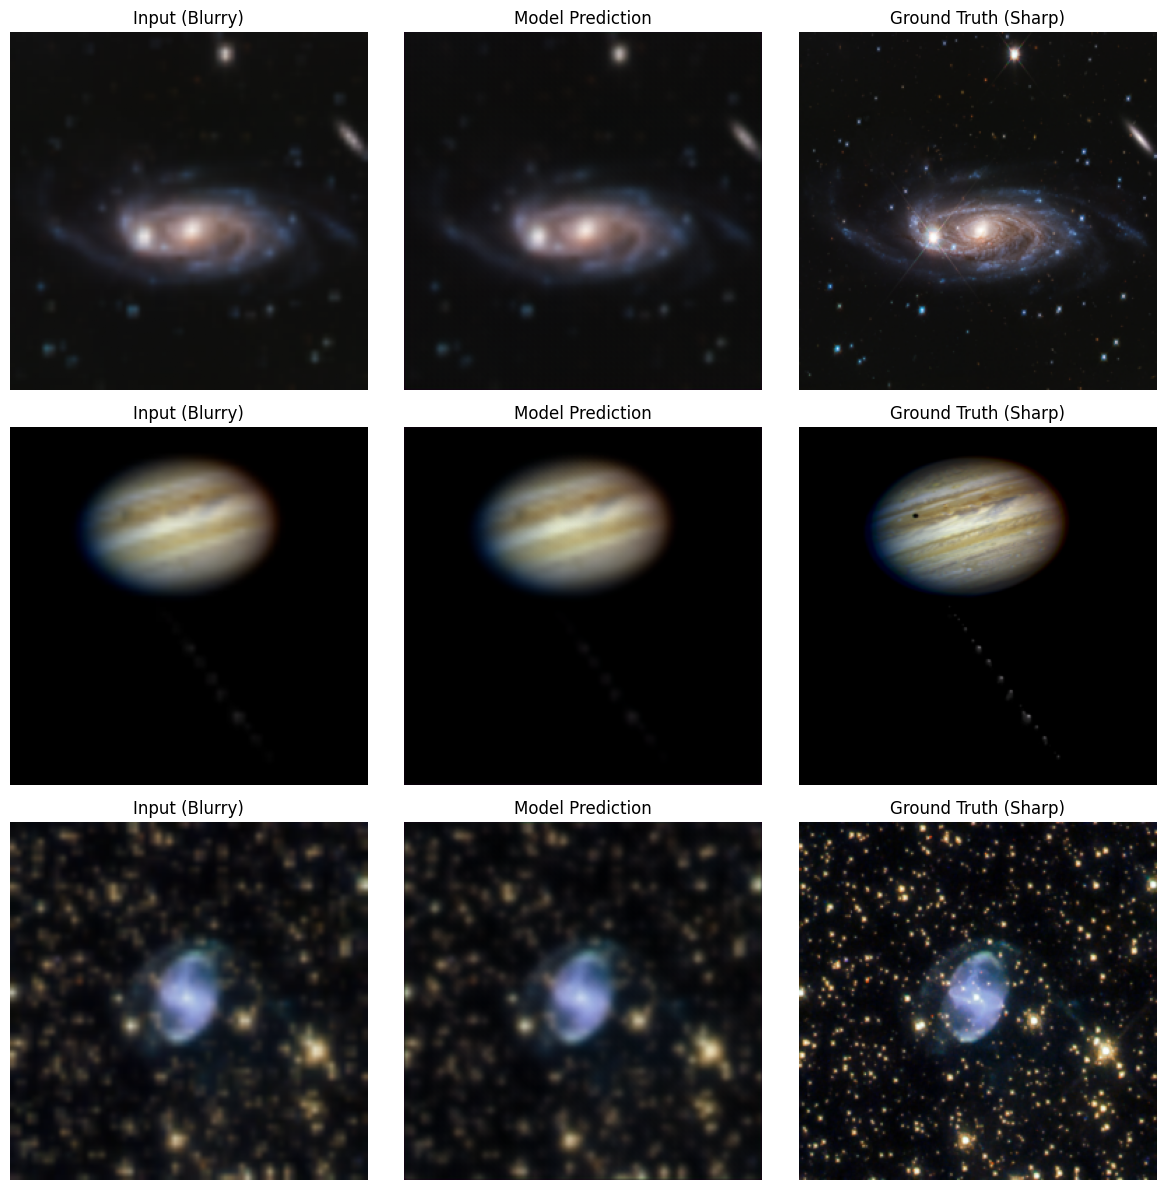

100%|██████████| 68/68 [38:21<00:00, 33.84s/it]


Epoch [6/10], Loss: 0.0869


100%|██████████| 68/68 [31:22<00:00, 27.68s/it]


Epoch [7/10], Loss: 0.0854


100%|██████████| 68/68 [22:35<00:00, 19.93s/it]


Epoch [8/10], Loss: 0.0842


100%|██████████| 68/68 [23:41<00:00, 20.90s/it]


Epoch [9/10], Loss: 0.0833


100%|██████████| 68/68 [32:06<00:00, 28.34s/it]  


Epoch [10/10], Loss: 0.0813
Creating visualization...


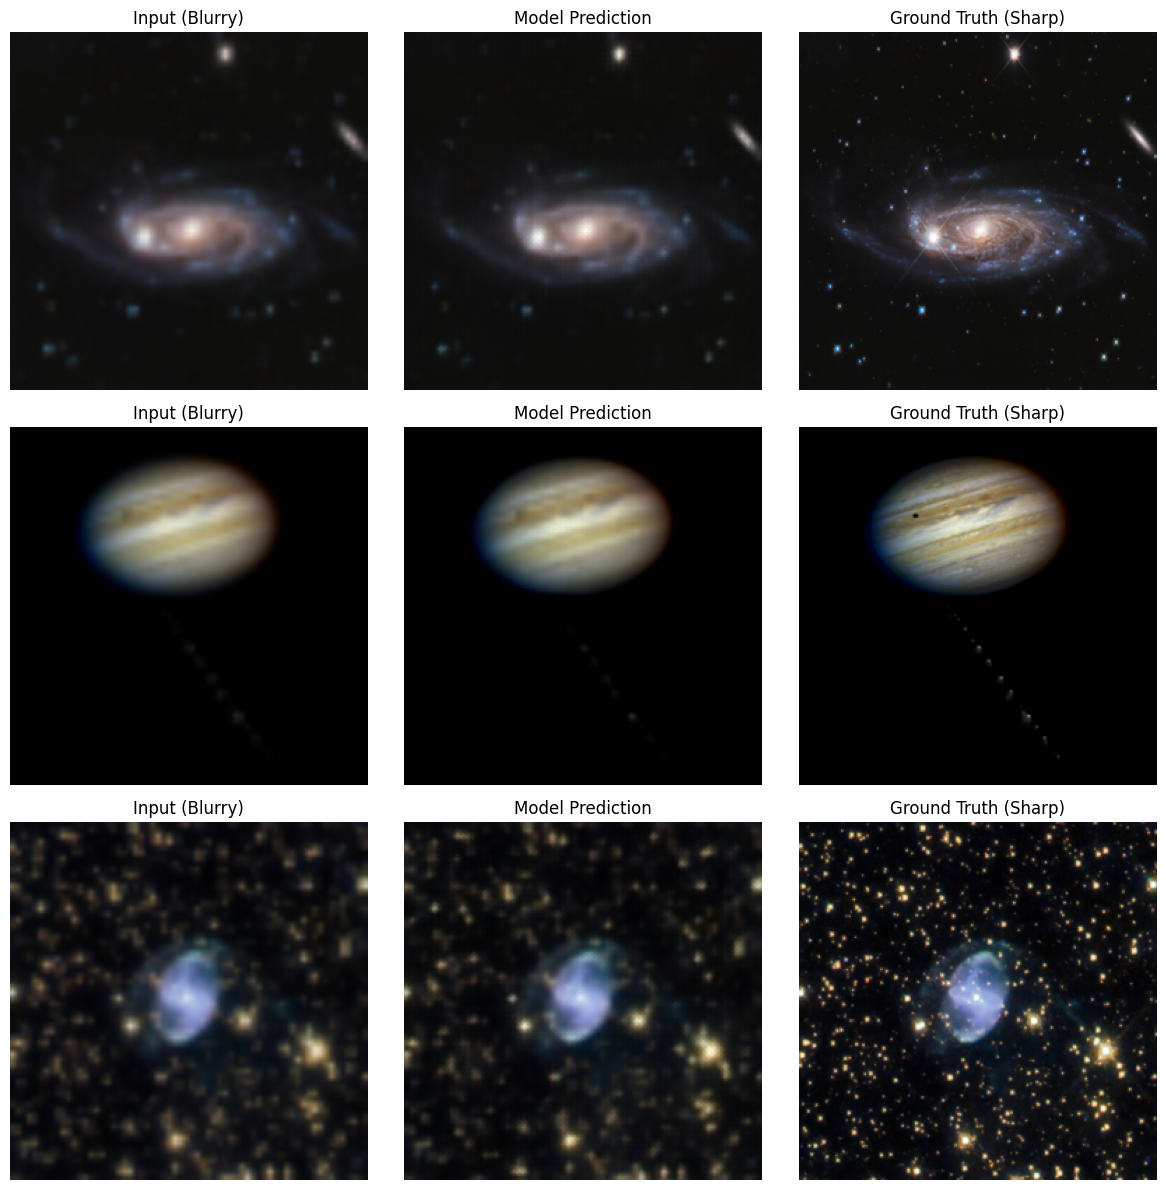

In [12]:
num_epochs = 10

Image.MAX_IMAGE_PIXELS = None

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_losses = []
    for low_res, high_res in tqdm(train_loader):
        low_res, high_res = low_res.to(device), high_res.to(device)

        optimizer.zero_grad()
        outputs = model(low_res)
        loss = criterion(outputs, high_res)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    
    # NEW: Visualize every 5 epochs
    if (epoch + 1) % 5 == 0:
        print("Creating visualization...")
        visualize_sample(model, test_loader, device)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.006396435..1.0003636].


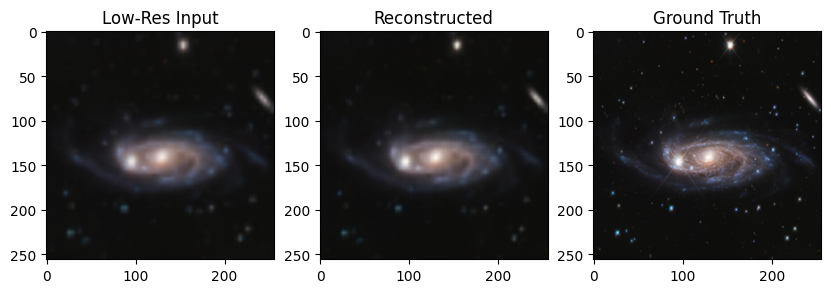

In [13]:
model.eval()
with torch.no_grad():
    sample_lr, sample_hr = next(iter(test_loader))
    sample_lr, sample_hr = sample_lr.to(device), sample_hr.to(device)
    pred = model(sample_lr)

# Convert tensor → image
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.title("Low-Res Input")
plt.imshow(np.transpose(sample_lr[0].cpu().numpy(), (1,2,0)))
plt.subplot(1,3,2)
plt.title("Reconstructed")
plt.imshow(np.transpose(pred[0].cpu().numpy(), (1,2,0)))
plt.subplot(1,3,3)
plt.title("Ground Truth")
plt.imshow(np.transpose(sample_hr[0].cpu().numpy(), (1,2,0)))
plt.show()


In [1]:
model.eval()
psnr_scores = []
ssim_scores = []

with torch.no_grad():
    for lr, hr in test_loader:
        lr, hr = lr.to(device), hr.to(device)
        pred = model(lr)
        pred = pred.clamp(0, 1)

        # Convert to numpy for metric calculation
        pred_np = np.transpose(pred[0].cpu().numpy(), (1,2,0))
        hr_np = np.transpose(hr[0].cpu().numpy(), (1,2,0))

        psnr_scores.append(calculate_psnr(pred_np, hr_np))
        ssim_scores.append(calculate_ssim(pred_np, hr_np))

print(f"🔍 PSNR: {np.mean(psnr_scores):.2f}, SSIM: {np.mean(ssim_scores):.3f}")


NameError: name 'model' is not defined

In [15]:
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric
import numpy as np

def evaluate_metrics(model, loader, device):
    model.eval()
    
    total_psnr = 0.0
    total_ssim = 0.0
    num_images = 0
    
    print("📊 Calculating metrics on Test Set...")
    
    with torch.no_grad():
        for low_res, high_res in tqdm(loader):
            low_res = low_res.to(device)
            high_res = high_res.to(device)
            
            # 1. Generate Prediction
            outputs = model(low_res)
            
            # 2. Convert to Numpy
            preds = outputs.cpu().clamp(0, 1).permute(0, 2, 3, 1).numpy()
            targets = high_res.cpu().clamp(0, 1).permute(0, 2, 3, 1).numpy()
            
            # 3. Calculate metrics for each image
            batch_size = preds.shape[0]
            for i in range(batch_size):
                p = preds[i]
                t = targets[i]
                
                # PSNR
                current_psnr = psnr_metric(t, p, data_range=1.0)
                
                # SSIM (Fixed)
                # We add a 'try-except' to handle different scikit-image versions
                try:
                    # Modern version
                    val = ssim_metric(t, p, data_range=1.0, channel_axis=2)
                except TypeError:
                    # Older version fallback
                    val = ssim_metric(t, p, data_range=1.0, multichannel=True)
                
                # SAFETY CHECK: If it returns a tuple (score, diff), take just the score
                if isinstance(val, tuple):
                    current_ssim = val[0]
                else:
                    current_ssim = val
                
                total_psnr += current_psnr
                total_ssim += current_ssim
                num_images += 1
                
    avg_psnr = total_psnr / num_images
    avg_ssim = total_ssim / num_images
    
    print("-" * 30)
    print(f"🌟 Final Results over {num_images} images:")
    print(f"   ➤ Average PSNR: {avg_psnr:.2f} dB")
    print(f"   ➤ Average SSIM: {avg_ssim:.4f}")
    print("-" * 30)
    
    return avg_psnr, avg_ssim

# --- How to run it ---
# Add this at the very bottom of your script (outside the loop):
evaluate_metrics(model, test_loader, device)

📊 Calculating metrics on Test Set...


  0%|          | 0/17 [00:00<?, ?it/s]

100%|██████████| 17/17 [00:07<00:00,  2.17it/s]

------------------------------
🌟 Final Results over 133 images:
   ➤ Average PSNR: 31.96 dB
   ➤ Average SSIM: 0.8559
------------------------------


(31.960860287573862, 0.8559285830286213)

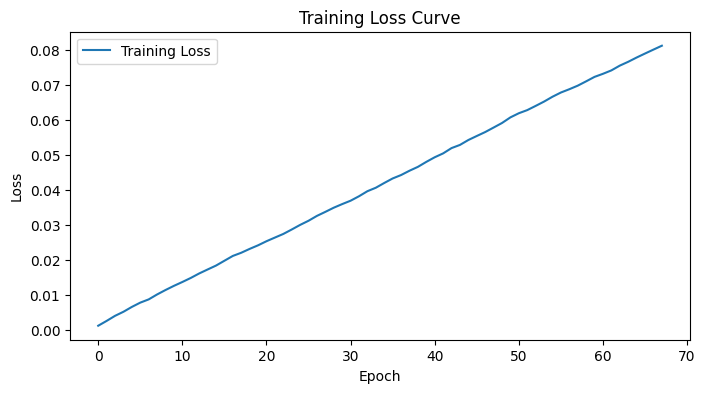

In [16]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()
